In [1]:
import torch
import torch.nn as nn

class ViT1Dmulticlass(nn.Module):
    def __init__(self, input_size, num_classes=4, patch_sizes=[20, 40], overlap=0.5, dim=128, depth=6, heads=8, 
                 mlp_dim=256, dropout=0.2, theta=30000, use_rope=True):
        super(ViT1Dmulticlass, self).__init__()
        if isinstance(patch_sizes, int):
            patch_sizes = [patch_sizes]
        self.num_branches = len(patch_sizes)
        self.dim = dim
        self.overlap = overlap
        self.use_rope = use_rope
        self.theta = theta
        self.branches = nn.ModuleList()
        
        # Set up branches for different patch sizes
        for patch_size in patch_sizes:
            stride = int(patch_size * (1 - overlap))
            max_patches = (input_size - patch_size) // stride + 1
            patch_embed = nn.Linear(patch_size, dim)
            transformer = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(dim, heads, mlp_dim, dropout), depth
            )
            self.branches.append(nn.ModuleDict({
                'patch_embed': patch_embed,
                'transformer': transformer
            }))

        # Learnable class token
        self.class_token = nn.Parameter(torch.zeros(1, 1, dim))

        # Cross-Attention for fusion of multiple patch sizes
        self.cross_attention = CrossAttentionBlock(dim, heads, theta=theta, use_rope=use_rope)

        # Classification head
        self.fc = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        batch_size, channels, seq_len = x.shape  # Assuming x has 3 dimensions
        x = x.squeeze(1) if channels == 1 else x  # Remove channel dimension if it's 1
        branch_outputs = []
        
        # Extract patches, embed, and process with transformer for each branch
        for branch in self.branches:
            patch_size = branch['patch_embed'].in_features
            stride = int(patch_size * (1 - self.overlap))
            num_patches = (seq_len - patch_size) // stride + 1
            patches = [x[:, i * stride : i * stride + patch_size] for i in range(num_patches)]
            x_branch = torch.stack(patches, dim=1)
            x_branch = branch['patch_embed'](x_branch)
            
            # Append class token and optionally apply RoPE
            class_token = self.class_token.expand(batch_size, -1, -1)
            x_branch = torch.cat((class_token, x_branch), dim=1)
            if self.use_rope:
                x_branch = apply_rope(x_branch, theta=self.theta)  # Apply RoPE here
            x_branch = branch['transformer'](x_branch)
            branch_outputs.append(x_branch)

        # Apply cross-attention to combine the representations from each branch
        x_fused = torch.cat(branch_outputs, dim=1)
        x_fused = self.cross_attention(x_fused)

        # Classification based on the class token representation
        x = self.fc(x_fused[:, 0])  # Use the class token at position 0 for classification
        return x


# Example Usage for Multi-label Classification
model = ViT1Dmulticlass(input_size=3748, num_classes=4)
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for multi-label tasks

# Dummy input
input_data = torch.rand(16, 1, 3748)  # Batch of 16 samples
labels = torch.randint(0, 2, (16, 4)).float()  # Multi-label binary targets

# Forward pass
outputs = model(input_data)
loss = criterion(outputs, labels)


C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


NameError: name 'CrossAttentionBlock' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ViT1Dmulticlass(nn.Module):
    def __init__(self, input_size, num_classes=4, patch_sizes=[20, 40], overlap=0.5, dim=128, depth=6, heads=8, 
                 mlp_dim=256, dropout=0.2, theta=30000, use_rope=True):
        super(ViT1Dmulticlass, self).__init__()
        if isinstance(patch_sizes, int):
            patch_sizes = [patch_sizes]
        self.num_branches = len(patch_sizes)
        self.dim = dim
        self.overlap = overlap
        self.use_rope = use_rope
        self.theta = theta
        self.branches = nn.ModuleList()
        
        # Set up branches for different patch sizes
        for patch_size in patch_sizes:
            stride = int(patch_size * (1 - overlap))
            max_patches = (input_size - patch_size) // stride + 1
            max_patches = (input_size // patch_size) ** 2
            patch_embed = nn.Linear(patch_size, dim)
            transformer = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(dim, heads, mlp_dim, dropout), depth
            )
            self.branches.append(nn.ModuleDict({
                'patch_embed': patch_embed,
                'transformer': transformer
            }))

        # Learnable class token
        self.class_token = nn.Parameter(torch.zeros(1, 1, dim))

        # Cross-Attention for fusion of multiple patch sizes
        self.cross_attention = CrossAttentionBlock(dim, heads, theta=theta, use_rope=use_rope)

        # Classification head
        self.fc = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        batch_size, channels, seq_len = x.shape  # Assuming x has 3 dimensions
        x = x.squeeze(1) if channels == 1 else x  # Remove channel dimension if it's 1
        branch_outputs = []
        
        # Extract patches, embed, and process with transformer for each branch
        for branch in self.branches:
            patch_size = branch['patch_embed'].in_features
            stride = int(patch_size * (1 - self.overlap))
            num_patches = (seq_len - patch_size) // stride + 1
            patches = [x[:, i * stride : i * stride + patch_size] for i in range(num_patches)]
            x_branch = torch.stack(patches, dim=1)
            x_branch = branch['patch_embed']  # Apply patch embedding
            
            # Append class token and optionally apply RoPE
            if self.use_rope:
                x_branch = apply_rope(x_branch, theta=self.theta)  # Apply RoPE here
            x_branch = branch['transformer']  # Apply transformer
            branch_outputs.append(x_branch)

        # Apply cross-attention to combine the representations from each branch
        x_fused = torch.cat(branch_outputs, dim=1)
        x_fused = self.cross_attention(x_fused)

        # Classification based on the class token representation
        x = self.fc(x_fused[:, 0])  # Use the class token at position 0 for classification
        return x


# Example usage
model = ViT1Dmulticlass(input_size=100, num_classes=4)
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for multilabel classification

# Dummy input
input_data = torch.rand(16, 1, 3748)  # Batch of 16 samples
labels = torch.randint(0, 2, (16, 4)).float()  # Multi-label binary targets

# Forward pass
outputs = model(input_data)
loss = criterion(outputs, labels)


AttributeError: 'Linear' object has no attribute 'shape'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import wandb
import gc
from sklearn.model_selection import train_test_split
from timm.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.vision_transformer import _cfg, Mlp, Block

# Create a custom Vision Transformer model
# Create dataset classes (using your BalancedDataset approach) and training function
class BalancedDataset(Dataset):
    def __init__(self, X, y, limit_per_label=1600):
        self.X = X
        self.y = y
        self.limit_per_label = limit_per_label
        self.classes = np.unique(y)
        self.indices = self.balance_classes()

    def balance_classes(self):
        indices = []
        for cls in self.classes:
            cls_indices = np.where(self.y == cls)[0]
            if len(cls_indices) > self.limit_per_label:
                cls_indices = np.random.choice(cls_indices, self.limit_per_label, replace=False)
            indices.extend(cls_indices)
        np.random.shuffle(indices)
        return indices

    def re_sample(self):
        self.indices = self.balance_classes()

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        index = self.indices[idx]
        return self.X[index], self.y[index]
# Custom Dataset for validation with limit per class
class BalancedValidationDataset(Dataset):
    def __init__(self, X, y, limit_per_label=400):
        self.X = X
        self.y = y
        self.limit_per_label = limit_per_label
        self.classes = np.unique(y)
        self.indices = self.balance_classes()

    def balance_classes(self):
        indices = []
        for cls in self.classes:
            cls_indices = np.where(self.y == cls)[0]
            if len(cls_indices) > self.limit_per_label:
                cls_indices = np.random.choice(cls_indices, self.limit_per_label, replace=False)
            indices.extend(cls_indices)
        np.random.shuffle(indices)
        return indices
    
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        index = self.indices[idx]
        return self.X[index], self.y[index]


# Training function with learning rate scheduler
def train_model_vit(model, train_loader, val_loader, test_loader, num_epochs=500, lr=1e-4, max_patience=20, device='cuda'):
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=int(max_patience/3), verbose=True)
    criterion = nn.CrossEntropyLoss()
    best_val_loss = float('inf')
    patience = max_patience
    
    for epoch in range(num_epochs):
        train_loader.dataset.re_sample()
        model.train()
        train_loss, train_accuracy = 0.0, 0.0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
            train_accuracy += (outputs.argmax(dim=1) == y_batch).float().mean().item()
        
        # Validation phase
        model.eval()
        val_loss, val_accuracy = 0.0, 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item() * X_val.size(0)
                val_accuracy += (outputs.argmax(dim=1) == y_val).float().mean().item()
        
        # Test phase
        test_loss, test_accuracy = 0.0, 0.0
        y_true, y_pred = [], []
        with torch.no_grad():
            for X_test, y_test in test_loader:
                X_test, y_test = X_test.to(device), y_test.to(device)
                outputs = model(X_test)
                loss = criterion(outputs, y_test)
                test_loss += loss.item() * X_test.size(0)
                test_accuracy += (outputs.argmax(dim=1) == y_test).float().mean().item()
                y_true.extend(y_test.cpu().numpy())
                y_pred.extend(outputs.argmax(dim=1).cpu().numpy())
        
        # Scheduler step
        scheduler.step(val_loss / len(val_loader.dataset))

        # Log metrics to WandB
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss / len(train_loader.dataset),
            "val_loss": val_loss / len(val_loader.dataset),
            "train_accuracy": train_accuracy / len(train_loader),
            "val_accuracy": val_accuracy / len(val_loader),
            "learning_rate": optimizer.param_groups[0]['lr'],
            "test_loss": test_loss / len(test_loader.dataset),
            "test_accuracy": test_accuracy / len(test_loader),
            "confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                y_true=y_true, preds=y_pred, class_names=np.unique(y_true)),
            "classification_report": classification_report(y_true, y_pred, target_names=label_mapping.keys())
        })
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = max_patience
        else:
            patience -= 1
            if patience <= 0:
                print("Early stopping triggered.")
                break

    return model

def init_rope_frequencies(dim, num_heads, theta, rotate=False):
    # Adjust the size of `mag` to match the per-head dimension
    per_head_dim = dim // ( num_heads)
    mag = 1 / (theta ** (torch.arange(0, per_head_dim).float() / (dim // num_heads))).unsqueeze(0)

    # Adjust `angles` accordingly
    angles = torch.rand(num_heads, per_head_dim//2) * 2 * torch.pi if rotate else torch.zeros(num_heads, per_head_dim//2)

    # Compute `freq_x` and `freq_y` with matching dimensions
    freq_x = mag * torch.cat([torch.cos(angles), torch.cos(torch.pi / 2 + angles)], dim=-1)
    freq_y = mag * torch.cat([torch.sin(angles), torch.sin(torch.pi / 2 + angles)], dim=-1)

    return torch.stack([freq_x, freq_y], dim=0)


def apply_rotary_position_embeddings(freqs, q, k):
    # Ensure `cos` and `sin` have the same shape as `q` and `k` by adding unsqueeze
    cos, sin = freqs[0].unsqueeze(1), freqs[1].unsqueeze(1)    
    
    # Broadcast `cos` and `sin` to match `q` and `k` dimensions
    q_rot = (q * cos) + (torch.roll(q, shifts=1, dims=-1) * sin)
    k_rot = (k * cos) + (torch.roll(k, shifts=1, dims=-1) * sin)
    
    return q_rot, k_rot
    
class CrossAttention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., theta = 30000):
        super().__init__()
        self.num_heads = num_heads
        self.dim = dim
        self.scale = qk_scale or (dim // num_heads) ** -0.5
        self.theta = theta

        self.wq = nn.Linear(dim, dim, bias=qkv_bias)
        self.wk = nn.Linear(dim, dim, bias=qkv_bias)
        self.wv = nn.Linear(dim, dim, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        
        # Initialize rotary frequencies
        self.freqs = init_rope_frequencies(dim, num_heads, theta)

    def forward(self, x):
        B, N, C = x.shape
        q = self.wq(x[:, 0:1, ...]).view(B, 1, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        k = self.wk(x).view(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        v = self.wv(x).view(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)

        # Apply rotary position embedding
        q_rot, k_rot = apply_rotary_position_embeddings(self.freqs.to(x.device), q, k)

        # Attention calculation with rotated embeddings
        attn = (q_rot @ k_rot.transpose(-2, -1)) * self.scale
        attn_no_rope = (q @ k.transpose(-2, -1)) * self.scale
        print(torch.abs(attn_no_rope - attn).mean())

        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        

        x = (attn @ v).transpose(1, 2).reshape(B, 1, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x
    
class CrossAttentionBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0., theta=30000,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, has_mlp=True):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = CrossAttention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop, theta=theta)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.has_mlp = has_mlp
        if has_mlp:
            self.norm2 = norm_layer(dim)
            mlp_hidden_dim = int(dim * mlp_ratio)
            self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x[:, 0:1, ...] + self.drop_path(self.attn(self.norm1(x)))
        if self.has_mlp:
            x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

class VisionTransformer1D(nn.Module):
    def __init__(self, input_size, num_classes=4, patch_sizes=[20, 40], overlap=0.5, dim=128, depth=6, heads=8, mlp_dim=256, dropout=0.2, theta = 30000):
        super(VisionTransformer1D, self).__init__()
        if isinstance(patch_sizes, int):
            patch_sizes = [patch_sizes]
        self.num_branches = len(patch_sizes)
        self.dim = dim
        self.overlap = overlap
        self.branches = nn.ModuleList()
        
        # Set up branches for different patch sizes
        for patch_size in patch_sizes:
            stride = int(patch_size * (1 - overlap))
            max_patches = (input_size - patch_size) // stride + 1
            max_patches = (input_size // patch_size) ** 2
            patch_embed = nn.Linear(patch_size, dim)
            #pos_embedding = nn.Embedding(max_patches + 1, dim)  # "+ 1" to account for class token
            transformer = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(dim, heads, mlp_dim, dropout), depth
            )
            self.branches.append(nn.ModuleDict({
                'patch_embed': patch_embed,
                #'pos_embedding': pos_embedding,
                'transformer': transformer
            }))

        # Learnable class token
        self.class_token = nn.Parameter(torch.zeros(1, 1, dim))

        # Cross-Attention for fusion of multiple patch sizes
        self.cross_attention = CrossAttentionBlock(dim, heads, theta=theta)

        # Classification head
        self.fc = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):

        batch_size, channels, seq_len = x.shape  # Assuming x has 3 dimensions
        x = x.squeeze(1) if channels == 1 else x  # Remove channel dimension if it's 1
        branch_outputs = []
        
        # Extract patches, embed, and process with transformer for each branch
        for branch in self.branches:
            patch_size = branch['patch_embed'].in_features
            stride = int(patch_size * (1 - self.overlap))
            num_patches = (seq_len - patch_size) // stride + 1
            patches = [x[:, i * stride : i * stride + patch_size] for i in range(num_patches)]
            x_branch = torch.stack(patches, dim=1)
            x_branch = branch['patch_embed'](x_branch)
            
            # Append class token and add positional embeddings
            class_token = self.class_token.expand(batch_size, -1, -1)
            x_branch = torch.cat((class_token, x_branch), dim=1)
            #x_branch = x_branch + branch['pos_embedding'](torch.arange(num_patches + 1, device=x.device)).unsqueeze(0)
            x_branch = branch['transformer'](x_branch)
            branch_outputs.append(x_branch)

        # Apply cross-attention to combine the representations from each branch
        x_fused = torch.cat(branch_outputs, dim=1)
        x_fused = self.cross_attention(x_fused)

        # Classification based on the class token representation
        x = self.fc(x_fused[:, 0])  # Use the class token at position 0 for classification
        return x

# Rotational Positional Encoding
class Rotary(torch.nn.Module):
    def __init__(self, dim, base):
        super().__init__()
        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer("inv_freq", inv_freq)
        self.seq_len_cached = None
        self.cos_cached = None
        self.sin_cached = None

    def forward(self, x, seq_dim=1):
        seq_len = x.shape[seq_dim]
        if seq_len != self.seq_len_cached:
            self.seq_len_cached = seq_len
            t = torch.arange(seq_len, device=x.device).type_as(self.inv_freq)
            freqs = torch.einsum("i,j->ij", t, self.inv_freq)
            emb = torch.cat((freqs, freqs), dim=-1).to(x.device)
            self.cos_cached = emb.cos()[None, :, None, :]
            self.sin_cached = emb.sin()[None, :, None, :]
        return self.cos_cached, self.sin_cached

def rotate_half(x):
    x1, x2 = x[..., : x.shape[-1] // 2], x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)

@torch.jit.script
def apply_rotary_pos_emb(q, k, cos, sin):
    return (q * cos) + (rotate_half(q) * sin), (k * cos) + (rotate_half(k) * sin)

# toggle rope 
class CrossAttention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., theta=30000, use_rope=True):
        super().__init__()
        self.num_heads = num_heads
        self.dim = dim
        self.scale = qk_scale or (dim // num_heads) ** -0.5
        self.theta = theta
        self.use_rope = use_rope  # New parameter to toggle RoPE
        
        self.wq = nn.Linear(dim, dim, bias=qkv_bias)
        self.wk = nn.Linear(dim, dim, bias=qkv_bias)
        self.wv = nn.Linear(dim, dim, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        if self.use_rope:
            # Initialize rotary frequencies if RoPE is enabled
            self.freqs = init_rope_frequencies(dim, num_heads, theta)

    def forward(self, x):
        B, N, C = x.shape
        q = self.wq(x[:, 0:1, ...]).view(B, 1, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        k = self.wk(x).view(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        v = self.wv(x).view(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)

        if self.use_rope:
            # Apply rotary position embedding if enabled
            q, k = apply_rotary_position_embeddings(self.freqs.to(x.device), q, k)

        # Attention calculation
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, 1, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x
class CrossAttentionBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0., theta=30000,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, has_mlp=True, use_rope=True):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = CrossAttention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop, theta=theta, use_rope=use_rope)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.has_mlp = has_mlp
        if has_mlp:
            self.norm2 = norm_layer(dim)
            mlp_hidden_dim = int(dim * mlp_ratio)
            self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x[:, 0:1, ...] + self.drop_path(self.attn(self.norm1(x)))
        if self.has_mlp:
            x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x
class VisionTransformer1D(nn.Module):
    def __init__(self, input_size, num_classes=4, patch_sizes=[20, 40], overlap=0.5, dim=128, depth=6, heads=8, 
                 mlp_dim=256, dropout=0.2, theta=30000, use_rope=True):
        super(VisionTransformer1D, self).__init__()
        if isinstance(patch_sizes, int):
            patch_sizes = [patch_sizes]
        self.num_branches = len(patch_sizes)
        self.dim = dim
        self.overlap = overlap
        self.use_rope = use_rope
        self.theta = theta
        self.branches = nn.ModuleList()
        
        # Set up branches for different patch sizes
        for patch_size in patch_sizes:
            stride = int(patch_size * (1 - overlap))
            max_patches = (input_size - patch_size) // stride + 1
            max_patches = (input_size // patch_size) ** 2
            patch_embed = nn.Linear(patch_size, dim)
            transformer = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(dim, heads, mlp_dim, dropout), depth
            )
            self.branches.append(nn.ModuleDict({
                'patch_embed': patch_embed,
                'transformer': transformer
            }))

        # Learnable class token
        self.class_token = nn.Parameter(torch.zeros(1, 1, dim))

        # Cross-Attention for fusion of multiple patch sizes
        self.cross_attention = CrossAttentionBlock(dim, heads, theta=theta, use_rope=use_rope)

        # Classification head
        self.fc = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        batch_size, channels, seq_len = x.shape  # Assuming x has 3 dimensions
        x = x.squeeze(1) if channels == 1 else x  # Remove channel dimension if it's 1
        branch_outputs = []
        
        # Extract patches, embed, and process with transformer for each branch
        for branch in self.branches:
            patch_size = branch['patch_embed'].in_features
            stride = int(patch_size * (1 - self.overlap))
            num_patches = (seq_len - patch_size) // stride + 1
            patches = [x[:, i * stride : i * stride + patch_size] for i in range(num_patches)]
            x_branch = torch.stack(patches, dim=1)
            x_branch = branch['patch_embed'](x_branch)
            
            # Append class token and optionally apply RoPE
            class_token = self.class_token.expand(batch_size, -1, -1)
            x_branch = torch.cat((class_token, x_branch), dim=1)
            if self.use_rope:
                x_branch = apply_rope(x_branch, theta=self.theta)  # Apply RoPE here
            x_branch = branch['transformer'](x_branch)
            branch_outputs.append(x_branch)

        # Apply cross-attention to combine the representations from each branch
        x_fused = torch.cat(branch_outputs, dim=1)
        x_fused = self.cross_attention(x_fused)

        # Classification based on the class token representation
        x = self.fc(x_fused[:, 0])  # Use the class token at position 0 for classification
        return x


# Helper Function: Apply RoPE
def apply_rope(x, theta):
    """
    Applies Rotary Positional Embeddings (RoPE) to the input tensor.
    :param x: Input tensor of shape [batch_size, seq_len, dim]
    :param theta: Scaling factor for RoPE
    :return: Tensor with RoPE applied
    """
    seq_len, dim = x.shape[1], x.shape[2]
    half_dim = dim // 2
    freqs = torch.exp(-torch.arange(0, half_dim, dtype=torch.float32, device=x.device) * np.log(theta) / half_dim)
    angles = torch.arange(seq_len, dtype=torch.float32, device=x.device).unsqueeze(1) * freqs.unsqueeze(0)
    cos_vals = torch.cos(angles)
    sin_vals = torch.sin(angles)

    x1, x2 = x[..., :half_dim], x[..., half_dim:]
    x_rope = torch.cat([x1 * cos_vals - x2 * sin_vals, x1 * sin_vals + x2 * cos_vals], dim=-1)
    return x_rope
import torch
import torch.nn as nn
import torch.nn.functional as F

class ViT1Dmulticlass(nn.Module):
    def __init__(self, input_size, num_classes=4, patch_sizes=[20, 40], overlap=0.5, dim=128, depth=6, heads=8, 
                 mlp_dim=256, dropout=0.2, theta=30000, use_rope=True):
        super(ViT1Dmulticlass, self).__init__()
        if isinstance(patch_sizes, int):
            patch_sizes = [patch_sizes]
        self.num_branches = len(patch_sizes)
        self.dim = dim
        self.overlap = overlap
        self.use_rope = use_rope
        self.theta = theta
        self.branches = nn.ModuleList()
        
        # Set up branches for different patch sizes
        for patch_size in patch_sizes:
            stride = int(patch_size * (1 - overlap))
            max_patches = (input_size - patch_size) // stride + 1
            max_patches = (input_size // patch_size) ** 2
            patch_embed = nn.Linear(patch_size, dim)
            transformer = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(dim, heads, mlp_dim, dropout), depth
            )
            self.branches.append(nn.ModuleDict({
                'patch_embed': patch_embed,
                'transformer': transformer
            }))

        # Learnable class token
        self.class_token = nn.Parameter(torch.zeros(1, 1, dim))

        # Cross-Attention for fusion of multiple patch sizes
        self.cross_attention = CrossAttentionBlock(dim, heads, theta=theta, use_rope=use_rope)

        # Classification head
        self.fc = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        batch_size, channels, seq_len = x.shape  # Assuming x has 3 dimensions
        x = x.squeeze(1) if channels == 1 else x  # Remove channel dimension if it's 1
        branch_outputs = []
        
        # Extract patches, embed, and process with transformer for each branch
        for branch in self.branches:
            patch_size = branch['patch_embed'].in_features
            stride = int(patch_size * (1 - self.overlap))
            num_patches = (seq_len - patch_size) // stride + 1
            patches = [x[:, i * stride : i * stride + patch_size] for i in range(num_patches)]
            x_branch = torch.stack(patches, dim=1)
            x_branch = branch['patch_embed']  # Apply patch embedding
            
            # Append class token and optionally apply RoPE
            if self.use_rope:
                x_branch = apply_rope(x_branch, theta=self.theta)  # Apply RoPE here
            x_branch = branch['transformer']  # Apply transformer
            branch_outputs.append(x_branch)

        # Apply cross-attention to combine the representations from each branch
        x_fused = torch.cat(branch_outputs, dim=1)
        x_fused = self.cross_attention(x_fused)

        # Classification based on the class token representation
        x = self.fc(x_fused[:, 0])  # Use the class token at position 0 for classification
        return x


# Example usage
model = ViT1Dmulticlass(input_size=100, num_classes=4)
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for multilabel classification

# Dummy input
input_data = torch.rand(16, 1, 3748)  # Batch of 16 samples
labels = torch.randint(0, 2, (16, 4)).float()  # Multi-label binary targets

# Forward pass
outputs = model(input_data)
loss = criterion(outputs, labels)



AttributeError: 'Linear' object has no attribute 'shape'

In [ ]:
how can i make my code multilabel classifier class, i attempted below VisionTransformer1D(nn.Module): 
    def __init__(self, input_size, num_classes=4, patch_sizes=[20, 40], overlap=0.5, dim=128, depth=6, heads=8, 
                 mlp_dim=256, dropout=0.2, theta=30000, use_rope=True):
        super(VisionTransformer1D, self).__init__()
        if isinstance(patch_sizes, int):
            patch_sizes = [patch_sizes]
        self.num_branches = len(patch_sizes)
        self.dim = dim
        self.overlap = overlap
        self.use_rope = use_rope
        self.theta = theta
        self.branches = nn.ModuleList()
        
        # Set up branches for different patch sizes
        for patch_size in patch_sizes:
            stride = int(patch_size * (1 - overlap))
            max_patches = (input_size - patch_size) // stride + 1
            max_patches = (input_size // patch_size) ** 2
            patch_embed = nn.Linear(patch_size, dim)
            transformer = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(dim, heads, mlp_dim, dropout), depth
            )
            self.branches.append(nn.ModuleDict({
                'patch_embed': patch_embed,
                'transformer': transformer
            }))

        # Learnable class token
        self.class_token = nn.Parameter(torch.zeros(1, 1, dim))

        # Cross-Attention for fusion of multiple patch sizes
        self.cross_attention = CrossAttentionBlock(dim, heads, theta=theta, use_rope=use_rope)

        # Classification head
        self.fc = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        batch_size, channels, seq_len = x.shape  # Assuming x has 3 dimensions
        x = x.squeeze(1) if channels == 1 else x  # Remove channel dimension if it's 1
        branch_outputs = []
        
        # Extract patches, embed, and process with transformer for each branch
        for branch in self.branches:
            patch_size = branch['patch_embed'].in_features
            stride = int(patch_size * (1 - self.overlap))
            num_patches = (seq_len - patch_size) // stride + 1
            patches = [x[:, i * stride : i * stride + patch_size] for i in range(num_patches)]
            x_branch = torch.stack(patches, dim=1)
            x_branch = branch['patch_embed'](x_branch)
            
            # Append class token and optionally apply RoPE
            class_token = self.class_token.expand(batch_size, -1, -1)
            x_branch = torch.cat((class_token, x_branch), dim=1)
            if self.use_rope:
                x_branch = apply_rope(x_branch, theta=self.theta)  # Apply RoPE here
            x_branch = branch['transformer'](x_branch)
            branch_outputs.append(x_branch)

        # Apply cross-attention to combine the representations from each branch
        x_fused = torch.cat(branch_outputs, dim=1)
        x_fused = self.cross_attention(x_fused)

        # Classification based on the class token representation
        x = self.fc(x_fused[:, 0])  # Use the class token at position 0 for classification
        return x
and i got this done 

class BalancedDataset(Dataset):
    def __init__(self, X, y, limit_per_label=1600):
        self.X = X
        self.y = y
        self.limit_per_label = limit_per_label
        self.classes = np.unique(y)
        self.indices = self.balance_classes()

    def balance_classes(self):
        indices = []
        for cls in self.classes:
            cls_indices = np.where(self.y == cls)[0]
            if len(cls_indices) > self.limit_per_label:
                cls_indices = np.random.choice(cls_indices, self.limit_per_label, replace=False)
            indices.extend(cls_indices)
        np.random.shuffle(indices)
        return indices

    def re_sample(self):
        self.indices = self.balance_classes()

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        index = self.indices[idx]
        return self.X[index], self.y[index]
# Custom Dataset for validation with limit per class
class BalancedValidationDataset(Dataset):
    def __init__(self, X, y, limit_per_label=400):
        self.X = X
        self.y = y
        self.limit_per_label = limit_per_label
        self.classes = np.unique(y)
        self.indices = self.balance_classes()

    def balance_classes(self):
        indices = []
        for cls in self.classes:
            cls_indices = np.where(self.y == cls)[0]
            if len(cls_indices) > self.limit_per_label:
                cls_indices = np.random.choice(cls_indices, self.limit_per_label, replace=False)
            indices.extend(cls_indices)
        np.random.shuffle(indices)
        return indices
    
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        index = self.indices[idx]
        return self.X[index], self.y[index]


# Training function with learning rate scheduler
def train_model_vit(model, train_loader, val_loader, test_loader, num_epochs=500, lr=1e-4, max_patience=20, device='cuda'):
    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=int(max_patience/3), verbose=True)
    criterion = nn.CrossEntropyLoss()
    best_val_loss = float('inf')
    patience = max_patience
    
    for epoch in range(num_epochs):
        train_loader.dataset.re_sample()
        model.train()
        train_loss, train_accuracy = 0.0, 0.0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
            train_accuracy += (outputs.argmax(dim=1) == y_batch).float().mean().item()
        
        # Validation phase
        model.eval()
        val_loss, val_accuracy = 0.0, 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                loss = criterion(outputs, y_val)
                val_loss += loss.item() * X_val.size(0)
                val_accuracy += (outputs.argmax(dim=1) == y_val).float().mean().item()
        
        # Test phase
        test_loss, test_accuracy = 0.0, 0.0
        y_true, y_pred = [], []
        with torch.no_grad():
            for X_test, y_test in test_loader:
                X_test, y_test = X_test.to(device), y_test.to(device)
                outputs = model(X_test)
                loss = criterion(outputs, y_test)
                test_loss += loss.item() * X_test.size(0)
                test_accuracy += (outputs.argmax(dim=1) == y_test).float().mean().item()
                y_true.extend(y_test.cpu().numpy())
                y_pred.extend(outputs.argmax(dim=1).cpu().numpy())
        
        # Scheduler step
        scheduler.step(val_loss / len(val_loader.dataset))

        # Log metrics to WandB
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss / len(train_loader.dataset),
            "val_loss": val_loss / len(val_loader.dataset),
            "train_accuracy": train_accuracy / len(train_loader),
            "val_accuracy": val_accuracy / len(val_loader),
            "learning_rate": optimizer.param_groups[0]['lr'],
            "test_loss": test_loss / len(test_loader.dataset),
            "test_accuracy": test_accuracy / len(test_loader),
            "confusion_matrix": wandb.plot.confusion_matrix(probs=None,
                y_true=y_true, preds=y_pred, class_names=np.unique(y_true)),
            "classification_report": classification_report(y_true, y_pred, target_names=label_mapping.keys())
        })
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = max_patience
        else:
            patience -= 1
            if patience <= 0:
                print("Early stopping triggered.")
                break

    return model

def init_rope_frequencies(dim, num_heads, theta, rotate=False):
    # Adjust the size of `mag` to match the per-head dimension
    per_head_dim = dim // ( num_heads)
    mag = 1 / (theta ** (torch.arange(0, per_head_dim).float() / (dim // num_heads))).unsqueeze(0)

    # Adjust `angles` accordingly
    angles = torch.rand(num_heads, per_head_dim//2) * 2 * torch.pi if rotate else torch.zeros(num_heads, per_head_dim//2)

    # Compute `freq_x` and `freq_y` with matching dimensions
    freq_x = mag * torch.cat([torch.cos(angles), torch.cos(torch.pi / 2 + angles)], dim=-1)
    freq_y = mag * torch.cat([torch.sin(angles), torch.sin(torch.pi / 2 + angles)], dim=-1)

    return torch.stack([freq_x, freq_y], dim=0)


def apply_rotary_position_embeddings(freqs, q, k):
    # Ensure `cos` and `sin` have the same shape as `q` and `k` by adding unsqueeze
    cos, sin = freqs[0].unsqueeze(1), freqs[1].unsqueeze(1)    
    
    # Broadcast `cos` and `sin` to match `q` and `k` dimensions
    q_rot = (q * cos) + (torch.roll(q, shifts=1, dims=-1) * sin)
    k_rot = (k * cos) + (torch.roll(k, shifts=1, dims=-1) * sin)
    
    return q_rot, k_rot

# Rotational Positional Encoding
class Rotary(torch.nn.Module):
    def __init__(self, dim, base):
        super().__init__()
        inv_freq = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer("inv_freq", inv_freq)
        self.seq_len_cached = None
        self.cos_cached = None
        self.sin_cached = None

    def forward(self, x, seq_dim=1):
        seq_len = x.shape[seq_dim]
        if seq_len != self.seq_len_cached:
            self.seq_len_cached = seq_len
            t = torch.arange(seq_len, device=x.device).type_as(self.inv_freq)
            freqs = torch.einsum("i,j->ij", t, self.inv_freq)
            emb = torch.cat((freqs, freqs), dim=-1).to(x.device)
            self.cos_cached = emb.cos()[None, :, None, :]
            self.sin_cached = emb.sin()[None, :, None, :]
        return self.cos_cached, self.sin_cached

def rotate_half(x):
    x1, x2 = x[..., : x.shape[-1] // 2], x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)

@torch.jit.script
def apply_rotary_pos_emb(q, k, cos, sin):
    return (q * cos) + (rotate_half(q) * sin), (k * cos) + (rotate_half(k) * sin)

# toggle rope 
class CrossAttention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., theta=30000, use_rope=True):
        super().__init__()
        self.num_heads = num_heads
        self.dim = dim
        self.scale = qk_scale or (dim // num_heads) ** -0.5
        self.theta = theta
        self.use_rope = use_rope  # New parameter to toggle RoPE
        
        self.wq = nn.Linear(dim, dim, bias=qkv_bias)
        self.wk = nn.Linear(dim, dim, bias=qkv_bias)
        self.wv = nn.Linear(dim, dim, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        if self.use_rope:
            # Initialize rotary frequencies if RoPE is enabled
            self.freqs = init_rope_frequencies(dim, num_heads, theta)

    def forward(self, x):
        B, N, C = x.shape
        q = self.wq(x[:, 0:1, ...]).view(B, 1, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        k = self.wk(x).view(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)
        v = self.wv(x).view(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)

        if self.use_rope:
            # Apply rotary position embedding if enabled
            q, k = apply_rotary_position_embeddings(self.freqs.to(x.device), q, k)

        # Attention calculation
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, 1, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x
class CrossAttentionBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0., theta=30000,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, has_mlp=True, use_rope=True):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = CrossAttention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop, theta=theta, use_rope=use_rope)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.has_mlp = has_mlp
        if has_mlp:
            self.norm2 = norm_layer(dim)
            mlp_hidden_dim = int(dim * mlp_ratio)
            self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x[:, 0:1, ...] + self.drop_path(self.attn(self.norm1(x)))
        if self.has_mlp:
            x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

# Helper Function: Apply RoPE
def apply_rope(x, theta):
    """
    Applies Rotary Positional Embeddings (RoPE) to the input tensor.
    :param x: Input tensor of shape [batch_size, seq_len, dim]
    :param theta: Scaling factor for RoPE
    :return: Tensor with RoPE applied
    """
    seq_len, dim = x.shape[1], x.shape[2]
    half_dim = dim // 2
    freqs = torch.exp(-torch.arange(0, half_dim, dtype=torch.float32, device=x.device) * np.log(theta) / half_dim)
    angles = torch.arange(seq_len, dtype=torch.float32, device=x.device).unsqueeze(1) * freqs.unsqueeze(0)
    cos_vals = torch.cos(angles)
    sin_vals = torch.sin(angles)

    x1, x2 = x[..., :half_dim], x[..., half_dim:]
    x_rope = torch.cat([x1 * cos_vals - x2 * sin_vals, x1 * sin_vals + x2 * cos_vals], dim=-1)
    return x_rope
import torch
import torch.nn as nn
import torch.nn.functional as F

class ViT1Dmulticlass(nn.Module):
    def __init__(self, input_size, num_classes=4, patch_sizes=[20, 40], overlap=0.5, dim=128, depth=6, heads=8, 
                 mlp_dim=256, dropout=0.2, theta=30000, use_rope=True):
        super(ViT1Dmulticlass, self).__init__()
        if isinstance(patch_sizes, int):
            patch_sizes = [patch_sizes]
        self.num_branches = len(patch_sizes)
        self.dim = dim
        self.overlap = overlap
        self.use_rope = use_rope
        self.theta = theta
        self.branches = nn.ModuleList()
        
        # Set up branches for different patch sizes
        for patch_size in patch_sizes:
            stride = int(patch_size * (1 - overlap))
            max_patches = (input_size - patch_size) // stride + 1
            max_patches = (input_size // patch_size) ** 2
            patch_embed = nn.Linear(patch_size, dim)
            transformer = nn.TransformerEncoder(
                nn.TransformerEncoderLayer(dim, heads, mlp_dim, dropout), depth
            )
            self.branches.append(nn.ModuleDict({
                'patch_embed': patch_embed,
                'transformer': transformer
            }))

        # Learnable class token
        self.class_token = nn.Parameter(torch.zeros(1, 1, dim))

        # Cross-Attention for fusion of multiple patch sizes
        self.cross_attention = CrossAttentionBlock(dim, heads, theta=theta, use_rope=use_rope)

        # Classification head
        self.fc = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        batch_size, channels, seq_len = x.shape  # Assuming x has 3 dimensions
        x = x.squeeze(1) if channels == 1 else x  # Remove channel dimension if it's 1
        branch_outputs = []
        
        # Extract patches, embed, and process with transformer for each branch
        for branch in self.branches:
            patch_size = branch['patch_embed'].in_features
            stride = int(patch_size * (1 - self.overlap))
            num_patches = (seq_len - patch_size) // stride + 1
            patches = [x[:, i * stride : i * stride + patch_size] for i in range(num_patches)]
            x_branch = torch.stack(patches, dim=1)
            x_branch = branch['patch_embed']  # Apply patch embedding
            
            # Append class token and optionally apply RoPE
            if self.use_rope:
                x_branch = apply_rope(x_branch, theta=self.theta)  # Apply RoPE here
            x_branch = branch['transformer']  # Apply transformer
            branch_outputs.append(x_branch)

        # Apply cross-attention to combine the representations from each branch
        x_fused = torch.cat(branch_outputs, dim=1)
        x_fused = self.cross_attention(x_fused)

        # Classification based on the class token representation
        x = self.fc(x_fused[:, 0])  # Use the class token at position 0 for classification
        return x


# Example usage
model = ViT1Dmulticlass(input_size=100, num_classes=4)
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for multilabel classification

# Dummy input
input_data = torch.rand(16, 1, 3748)  # Batch of 16 samples
labels = torch.randint(0, 2, (16, 4)).float()  # Multi-label binary targets

# Forward pass
outputs = model(input_data)
loss = criterion(outputs, labels)



SyntaxError: invalid syntax (920498887.py, line 1)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Generate Data
def generate_data(num_samples=1000, seq_length=50, noise_level=0.1):
    data = []
    labels = []
    for _ in range(num_samples):
        # Class 0: Line up
        line_up = np.linspace(0, 1, seq_length) + np.random.normal(0, noise_level, seq_length)
        data.append(line_up)
        labels.append(0)
        
        # Class 1: Line down
        line_down = np.linspace(1, 0, seq_length) + np.random.normal(0, noise_level, seq_length)
        data.append(line_down)
        labels.append(1)
        
    data = np.array(data, dtype=np.float64)
    labels = np.array(labels, dtype=np.float64)
    return data, labels

# Plot the data
def plot_data(data, labels, num_samples=5):
    plt.figure(figsize=(10, 6))
    for i in range(num_samples):
        plt.plot(data[i], label=f"Class {labels[i]}")
    plt.legend()
    plt.title("Sample Data")
    plt.show()

# Model
class SimpleTransformer(nn.Module):
    def __init__(self, seq_length, num_classes):
        super(SimpleTransformer, self).__init__()
        self.embedding = nn.Linear(seq_length, 128)  # Expands from seq_length to d_model
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=128, nhead=4, dim_feedforward=256),
            num_layers=2,
        )
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        # Apply transformer
        x = self.transformer(x)
        # Pooling: (seq_len, batch_size, d_model) -> (batch_size, d_model)
        x = x.mean(dim=0)
        # Final classification
        x = self.fc(x)
        return x

# Hyperparameters
seq_length = 50
num_classes = 2
learning_rate = 0.001
batch_size = 32
num_epochs = 10

# Data
data, labels = generate_data()
dataset = TensorDataset(torch.tensor(data), torch.tensor(labels))
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model, Loss, Optimizer
model = SimpleTransformer(seq_length, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    with tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
        for batch_data, batch_labels in tepoch:
            batch_data = batch_data.float()  # Ensure data is float
            optimizer.zero_grad()
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_labels).sum().item()
            tepoch.set_postfix(loss=loss.item())
    
    accuracy = correct / len(dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")



Epoch 1/10:   0%|          | 0/63 [00:00<?, ?batch/s]


AssertionError: was expecting embedding dimension of 128, but got 50

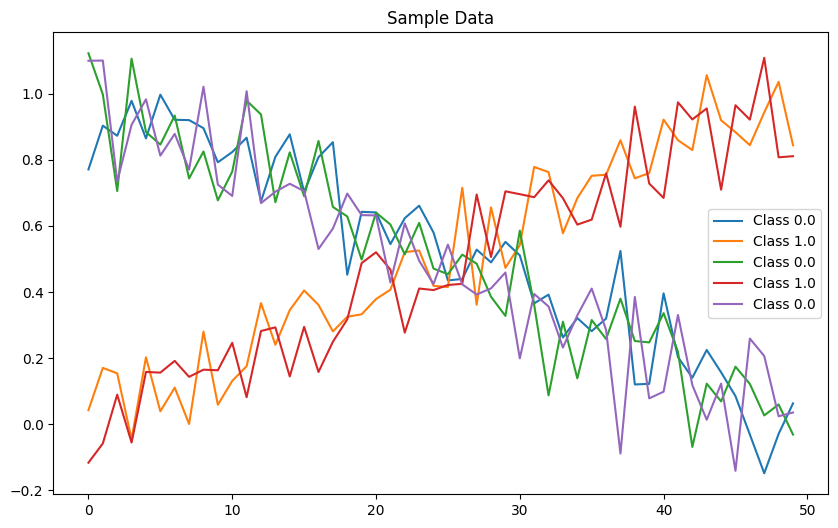

Epoch 1/10: 100%|██████████| 63/63 [00:00<00:00, 132.74batch/s, loss=0.000148]


Epoch 1/10, Loss: 1.9290, Accuracy: 0.9870


Epoch 2/10: 100%|██████████| 63/63 [00:00<00:00, 122.19batch/s, loss=0.000116]


Epoch 2/10, Loss: 0.0079, Accuracy: 1.0000


Epoch 3/10: 100%|██████████| 63/63 [00:00<00:00, 120.32batch/s, loss=0.000102]


Epoch 3/10, Loss: 0.0069, Accuracy: 1.0000


Epoch 4/10: 100%|██████████| 63/63 [00:00<00:00, 111.90batch/s, loss=9.56e-5] 


Epoch 4/10, Loss: 0.0061, Accuracy: 1.0000


Epoch 5/10: 100%|██████████| 63/63 [00:00<00:00, 113.48batch/s, loss=8.31e-5]


Epoch 5/10, Loss: 0.0054, Accuracy: 1.0000


Epoch 6/10: 100%|██████████| 63/63 [00:00<00:00, 117.41batch/s, loss=6.74e-5]


Epoch 6/10, Loss: 0.0048, Accuracy: 1.0000


Epoch 7/10: 100%|██████████| 63/63 [00:00<00:00, 121.73batch/s, loss=6.58e-5]


Epoch 7/10, Loss: 0.0042, Accuracy: 1.0000


Epoch 8/10: 100%|██████████| 63/63 [00:00<00:00, 123.87batch/s, loss=6.17e-5]


Epoch 8/10, Loss: 0.0037, Accuracy: 1.0000


Epoch 9/10: 100%|██████████| 63/63 [00:00<00:00, 120.99batch/s, loss=5.04e-5]


Epoch 9/10, Loss: 0.0033, Accuracy: 1.0000


Epoch 10/10: 100%|██████████| 63/63 [00:00<00:00, 120.36batch/s, loss=4.39e-5]

Epoch 10/10, Loss: 0.0029, Accuracy: 1.0000


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Generate Data
def generate_data(num_samples=1000, seq_length=50, noise_level=0.1):
    data = []
    labels = []
    for _ in range(num_samples):
        # Class 0: Line up
        line_up = np.linspace(1, 0, seq_length) + np.random.normal(0, noise_level, seq_length)
        data.append(line_up)
        labels.append(0)
        
        # Class 1: Line down
        line_down = np.linspace(0, 1, seq_length) + np.random.normal(0, noise_level, seq_length)
        data.append(line_down)
        labels.append(1)
        
    data = np.array(data, dtype=np.float64)
    labels = np.array(labels, dtype=np.float64)
    return data, labels

# Plot the data
def plot_data(data, labels, num_samples=5):
    plt.figure(figsize=(10, 6))
    for i in range(num_samples):
        plt.plot(data[i], label=f"Class {labels[i]}")
    plt.legend()
    plt.title("Sample Data")
    plt.show()

# Model
class SimpleTransformer(nn.Module):
    def __init__(self, seq_length, num_classes):
        super(SimpleTransformer, self).__init__()
        self.embedding = nn.Linear(seq_length, 128)  # Expands from seq_length to d_model
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=128, nhead=4, dim_feedforward=256),
            num_layers=2,
        )
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        # Apply embedding
        x = self.embedding(x)
        # Apply transformer
        x = self.transformer(x)
        # Pooling: (seq_len, batch_size, d_model) -> (batch_size, d_model)
        #x = x.mean(dim=0)
        # Final classification
        x = self.fc(x)
        return x

# Hyperparameters
seq_length = 50
num_classes = 2
learning_rate = 0.001
batch_size = 32
num_epochs = 10

# Data
data, labels = generate_data()
dataset = TensorDataset(torch.tensor(data), torch.tensor(labels))
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Plot the data
plot_data(data, labels)

# Model, Loss, Optimizer
model = SimpleTransformer(seq_length, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    with tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
        for batch_data, batch_labels in tepoch:
            batch_data = batch_data.float()  # Ensure data is float 
            optimizer.zero_grad()
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels.long())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_labels).sum().item()
            tepoch.set_postfix(loss=loss.item())
    
    accuracy = correct / len(dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")



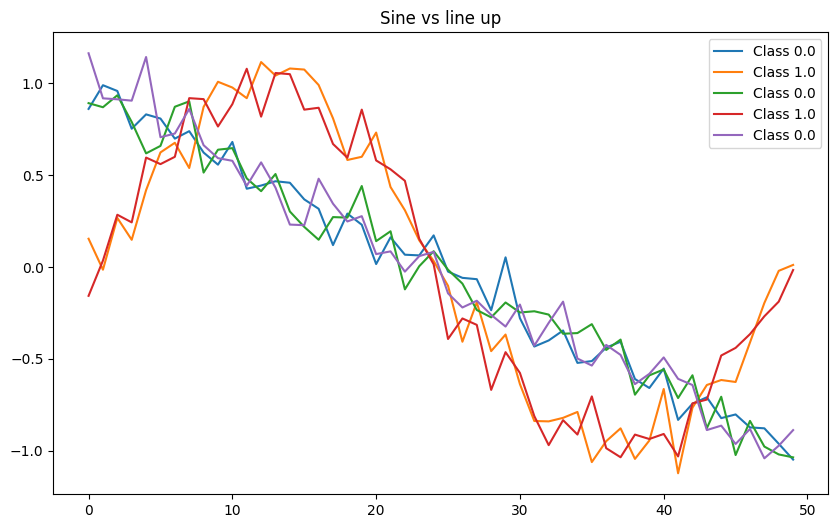

SimpleTransformer(
  (embedding): Linear(in_features=1, out_features=128, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Sequential(
    (0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=128, out_features=2, bias=True)
  )
)


Epoch 1/10: 100%|██████████| 63/63 [00:01<00:00, 33.97batch/s, loss=0.207]


Epoch 1/10, Loss: 34.1255, Accuracy: 0.6605


Epoch 2/10: 100%|██████████| 63/63 [00:01<00:00, 35.06batch/s, loss=0.000381]


Epoch 2/10, Loss: 2.2721, Accuracy: 0.9860


Epoch 3/10: 100%|██████████| 63/63 [00:01<00:00, 34.91batch/s, loss=0.00289] 


Epoch 3/10, Loss: 1.0534, Accuracy: 0.9965


Epoch 4/10: 100%|██████████| 63/63 [00:01<00:00, 32.83batch/s, loss=0.000807]


Epoch 4/10, Loss: 1.6151, Accuracy: 0.9925


Epoch 5/10: 100%|██████████| 63/63 [00:01<00:00, 34.51batch/s, loss=0.000104]


Epoch 5/10, Loss: 0.0382, Accuracy: 1.0000


Epoch 6/10: 100%|██████████| 63/63 [00:01<00:00, 35.89batch/s, loss=7.99e-5] 


Epoch 6/10, Loss: 0.0085, Accuracy: 1.0000


Epoch 7/10: 100%|██████████| 63/63 [00:01<00:00, 35.00batch/s, loss=0.00053] 


Epoch 7/10, Loss: 5.6999, Accuracy: 0.9575


Epoch 8/10: 100%|██████████| 63/63 [00:01<00:00, 37.21batch/s, loss=0.000133]


Epoch 8/10, Loss: 0.2454, Accuracy: 0.9985


Epoch 9/10: 100%|██████████| 63/63 [00:01<00:00, 37.24batch/s, loss=0.000105]


Epoch 9/10, Loss: 0.0083, Accuracy: 1.0000


Epoch 10/10: 100%|██████████| 63/63 [00:01<00:00, 37.24batch/s, loss=6.75e-5] 

Epoch 10/10, Loss: 0.0055, Accuracy: 1.0000


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Generate Data
def generate_data(num_samples=1000, seq_length=50, noise_level=0.1):
    data = []
    labels = []
    for _ in range(num_samples):
        # Class 0: Line up
        line_up = np.linspace(1, -1 , seq_length) + np.random.normal(0, noise_level, seq_length)
        data.append(line_up)
        labels.append(0)

        # Class 1: Sinusoidal
        sinusoidal = np.sin(np.linspace(0, 2 * np.pi, seq_length)) + np.random.normal(0, noise_level, seq_length)
        data.append(sinusoidal)
        labels.append(1)
        
        # Class 1: Line down
        #line_down = np.linspace(0, 1, seq_length) + np.random.normal(0, noise_level, seq_length)
        #data.append(line_down)
        #labels.append(1)
        
    data = np.array(data, dtype=np.float64)
    labels = np.array(labels, dtype=np.float64)
    return data, labels

# Plot the data
def plot_data(data, labels, num_samples=5):
    plt.figure(figsize=(10, 6))
    for i in range(num_samples):
        plt.plot(data[i], label=f"Class {labels[i]}")
    plt.legend()
    plt.title("Sample data")
    plt.show()

class SimpleTransformer(nn.Module):
    def __init__(self, input_dim, d_model, num_classes):
        super(SimpleTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)  # Embedding for each token
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=4, dim_feedforward=256),
            num_layers=2,
        )
        self.fc = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, num_classes),
        )

    def forward(self, x):
        # Apply embedding: (seq_len, batch_size, input_dim) -> (seq_len, batch_size, d_model)
        x = self.embedding(x)
        # Apply transformer: (seq_len, batch_size, d_model)
        x = self.transformer(x)
        # Pooling: (seq_len, batch_size, d_model) -> (batch_size, d_model)
        x = x.mean(dim=0)
        # Final classification: (batch_size, num_classes)
        x = self.fc(x)
        return x


# Hyperparameters
input_dim = 1  # Each data point is a token
d_model = 128
num_classes = 2
learning_rate = 0.001
batch_size = 32
num_epochs = 10

# Data
data, labels = generate_data(noise_level=0.1)

# Plot the data
plot_data(data.squeeze(), labels)

# Model, Loss, Optimizer
model = SimpleTransformer(input_dim, d_model, num_classes)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Reshape data to include the input_dim dimension
data = data.reshape(-1, seq_length, 1)  # Reshape data to (num_samples, seq_length, input_dim)
dataset = TensorDataset(torch.tensor(data, dtype=torch.float32), torch.tensor(labels, dtype=torch.long))
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    with tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
        for batch_data, batch_labels in tepoch:
            optimizer.zero_grad()
            # Transpose batch_data to match the expected input shape of the transformer (seq_len, batch_size, input_dim)
            batch_data = batch_data.transpose(0, 1)
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_labels).sum().item()
            tepoch.set_postfix(loss=loss.item())
    
    accuracy = correct / len(dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")


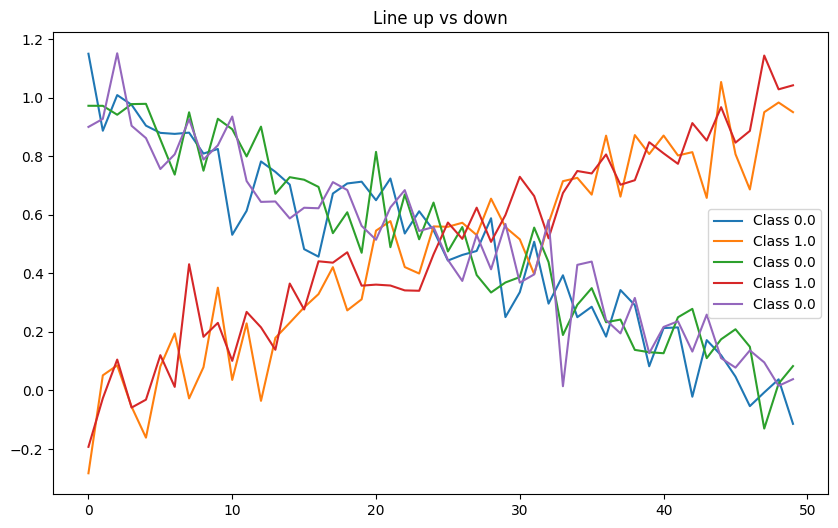

SimpleTransformer(
  (embedding): Linear(in_features=1, out_features=128, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Sequential(
    (0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=128, out_features=2, bias=True)
  )
)


Epoch 1/10: 100%|██████████| 63/63 [00:01<00:00, 34.98batch/s, loss=0.718]


Epoch 1/10, Loss: 46.0660, Accuracy: 0.4955


Epoch 2/10: 100%|██████████| 63/63 [00:01<00:00, 37.31batch/s, loss=0.686]


Epoch 2/10, Loss: 44.2977, Accuracy: 0.5080


Epoch 3/10: 100%|██████████| 63/63 [00:01<00:00, 36.75batch/s, loss=0.687]


Epoch 3/10, Loss: 44.0546, Accuracy: 0.5100


Epoch 4/10: 100%|██████████| 63/63 [00:01<00:00, 34.68batch/s, loss=0.688]


Epoch 4/10, Loss: 44.3918, Accuracy: 0.5060


Epoch 5/10: 100%|██████████| 63/63 [00:01<00:00, 31.67batch/s, loss=0.698]


Epoch 5/10, Loss: 43.9584, Accuracy: 0.4985


Epoch 6/10: 100%|██████████| 63/63 [00:01<00:00, 35.03batch/s, loss=0.699]


Epoch 6/10, Loss: 44.2898, Accuracy: 0.5085


Epoch 7/10: 100%|██████████| 63/63 [00:01<00:00, 33.43batch/s, loss=0.668]


Epoch 7/10, Loss: 43.7858, Accuracy: 0.5010


Epoch 8/10: 100%|██████████| 63/63 [00:02<00:00, 28.76batch/s, loss=0.695]


Epoch 8/10, Loss: 43.8731, Accuracy: 0.4950


Epoch 9/10: 100%|██████████| 63/63 [00:02<00:00, 28.61batch/s, loss=0.706]


Epoch 9/10, Loss: 43.9145, Accuracy: 0.4850


Epoch 10/10: 100%|██████████| 63/63 [00:01<00:00, 32.16batch/s, loss=0.676]

Epoch 10/10, Loss: 43.7546, Accuracy: 0.5120


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Generate Data
def generate_data(num_samples=1000, seq_length=50, noise_level=0.1):
    data = []
    labels = []
    for _ in range(num_samples):
        # Class 0: Line up
        line_up = np.linspace(1, 0, seq_length) + np.random.normal(0, noise_level, seq_length)
        data.append(line_up)
        labels.append(0)

        # Class 1: Sinusoidal
        #sinusoidal = np.sin(np.linspace(0, 2 * np.pi, seq_length)) + np.random.normal(0, noise_level, seq_length)
        #data.append(sinusoidal)
        #labels.append(1)
        
        # Class 1: Line down
        line_down = np.linspace(0, 1, seq_length) + np.random.normal(0, noise_level, seq_length)
        data.append(line_down)
        labels.append(1)
        
    data = np.array(data, dtype=np.float64)
    labels = np.array(labels, dtype=np.float64)
    return data, labels

# Plot the data
def plot_data(data, labels, num_samples=5):
    plt.figure(figsize=(10, 6))
    for i in range(num_samples):
        plt.plot(data[i], label=f"Class {labels[i]}")
    plt.legend()
    plt.title("Line up vs down")
    plt.show()

class SimpleTransformer(nn.Module):
    def __init__(self, input_dim, d_model, num_classes):
        super(SimpleTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)  # Embedding for each token
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=4, dim_feedforward=256),
            num_layers=2,
        )
        self.fc = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, num_classes),
        )

    def forward(self, x):
        # Apply embedding: (seq_len, batch_size, input_dim) -> (seq_len, batch_size, d_model)
        x = self.embedding(x)
        # Apply transformer: (seq_len, batch_size, d_model)
        x = self.transformer(x)
        # Pooling: (seq_len, batch_size, d_model) -> (batch_size, d_model)
        x = x.mean(dim=0)
        # Final classification: (batch_size, num_classes)
        x = self.fc(x)
        return x


# Hyperparameters
input_dim = 1  # Each data point is a token
d_model = 128
num_classes = 2
learning_rate = 0.001
batch_size = 32
num_epochs = 10

# Data
data, labels = generate_data()

# Plot the data
plot_data(data.squeeze(), labels)

# Model, Loss, Optimizer
model = SimpleTransformer(input_dim, d_model, num_classes)
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Reshape data to include the input_dim dimension
data = data.reshape(-1, 50, 1)  # Reshape data to (num_samples, seq_length, input_dim)
dataset = TensorDataset(torch.tensor(data, dtype=torch.float32), torch.tensor(labels, dtype=torch.long))
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    with tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
        for batch_data, batch_labels in tepoch:
            optimizer.zero_grad()
            # Transpose batch_data to match the expected input shape of the transformer (seq_len, batch_size, input_dim)
            batch_data = batch_data.transpose(0, 1)
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_labels).sum().item()
            tepoch.set_postfix(loss=loss.item())
    
    accuracy = correct / len(dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")
